In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import os
import contextlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import corner

from pool_utils import build_pool  # new helper
from burstfit_pipeline import BurstPipeline  # OO façade

from burstfit_robust import (
    spectral_index_evolution, 
    dm_optimization_check,
    scintillation_analysis,
    time_frequency_drift_check,
    bootstrap_uncertainties
)

from burstfit import (
    FRBModel,
    FRBFitter,
    FRBParams,
    build_priors,
    plot_dynamic,
    goodness_of_fit
)

In [2]:
# Setup multiprocessing
pool = build_pool(n_requested=8) # auto-detect avai and prompt
# If running non-interactively, skip the prompt:
# pool = build_pool(auto_ok=True)

[BurstFit] running with nproc=8


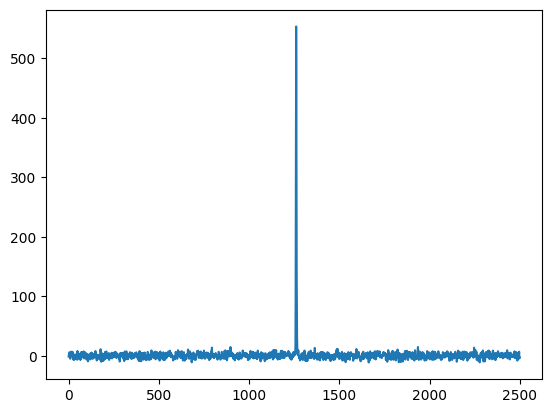

TypeError: __init__() got an unexpected keyword argument 'sampler_name'

In [3]:
# Check burst spectrum
name = 'casey'
basedir = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/DSA_bursts/'
npys = os.listdir(f'{basedir}')
npy = [i for i in npys if f'{name}' in i][0]
dyn = np.load(os.path.join(basedir, npy))
plt.plot(np.nansum(dyn,axis=0))
plt.show()

# Setup the pipeline
name = 'casey'
basedir = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/DSA_bursts/'
npys = os.listdir(f'{basedir}')
npy = [i for i in npys if f'{name}' in i][0]
ds_path = os.path.join(basedir, npy)
tel_key = "DSA-110"             # key in telescopes.yaml

pipe = BurstPipeline(
    path           = ds_path,         
    telescope      = "DSA-110",
    telcfg_path    = "telescopes.yaml", 
    sampcfg_path   = "sampler.yaml",
    sampler_name   = None,   # or "dynesty", etc. to override YAML default
    #
    # Fitter
    n_steps        = 2000,
    pool           = pool,
    #
    # Dataset pre-processing
    f_factor       = 384,
    t_factor       = 1,
    outer_trim     = 0.49,
    center_burst   = True,
    smooth_ms      = 0.5,
)

# Quick-look the raw dynamic spectrum
pipe.dataset.quicklook()

for key in ("M0","M1","M2","M3"):
    p0  = pipe.fitter._guess()
    mdl = pipe.dataset.time.size
    ll  = pipe.fitter.model.log_likelihood(p0, key)
    print(f"{key}: logL = {ll:.1f}")
    
# Run the pipeline
result = pipe.run_full(
    model_scan=True,        # evaluates M0–M3, picks by BIC
    diagnostics=True,       # sub-band & leave-1-out tests
    plot=True,              # data, model, residual, influence bar
)

# After running the pipeline, display subband consistency results
if result["diagnostics"]:
    diag = result["diagnostics"]
    
    
    subband_results = diag.ds.__dict__.get('_subband_results', None)
    if subband_results and best_key in ["M2", "M3"]:
        print("\nSubband Consistency Test:")
        print("Band | τ_mean ± τ_std [ms]")
        print("-" * 30)
        for i, (tau_mean, tau_std) in enumerate(subband_results):
            print(f"{i+1:4d} | {tau_mean:.3f} ± {tau_std:.3f}")
            
# Examine the results
best_key   = result["best_key"]
best_pars  = result["best_params"]
sampler    = result["sampler"]

print("Best model :", best_key)
print("Parameters :", best_pars)

# Corner plot of posterior (discard burn-in, thin = 5)
flat = sampler.get_chain(discard=sampler.iteration//4, 
                         thin=5, flat=True)
fig  = corner.corner(flat, labels=list(best_pars.__dict__), 
                     show_titles=True)

#with contextlib.suppress(Exception):
#    pool.close(); pool.join()


N/50 = 20;
tau: [ 23.76264813  52.53349207 121.4277453   70.5260855 ]


Detected burn-in: 113 steps
Using thinning: 20
Final samples: 1408 (from 32000 total)
Removed 2 outlier samples
Chain Health Check:
  Log-prob stability: 13877.16 (want < 1.0)
  Parameter drift: 0.05 (want < 0.1)
  ⚠️  Chains may need more steps!
  Consider running: sampler.run_mcmc(None, 1000, progress=True)
Running additional MCMC steps...


100%|██████████| 1000/1000 [00:07<00:00, 132.61it/s]
N/50 = 40;
tau: [ 24.90825488  70.0580494  197.10432871  91.80988466]


Detected burn-in: 113 steps
Using thinning: 20
Final samples: 3008 (from 64000 total)
Removed 4 outlier samples

Parameter Summary (median [16%, 84%]):
c0: 0.050 [-0.021, 0.052]
t0: 0.329 [0.327, 0.330]
gamma: -3.994 [-3.999, -0.450]
zeta: 0.049 [0.047, 0.173]


AttributeError: 'ChainConsumer' object has no attribute 'add_truth'

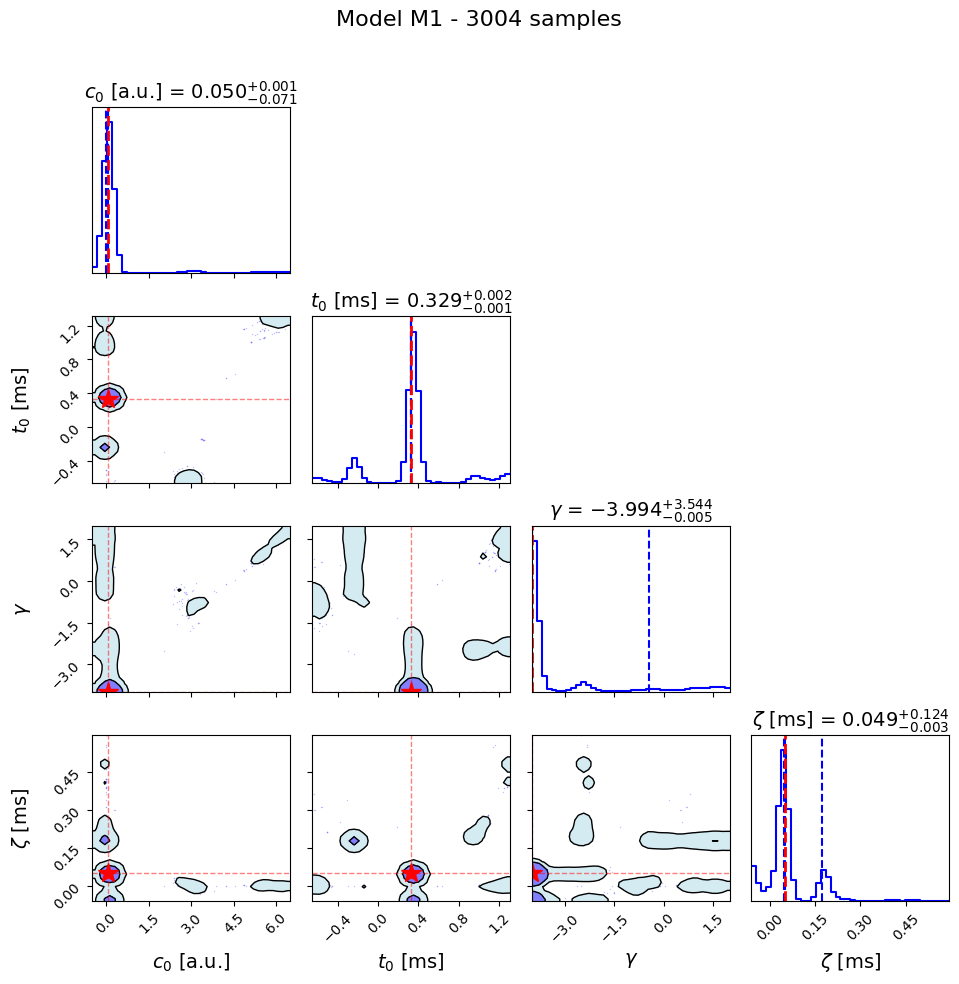

In [3]:
from burstfit_corner import (
        get_clean_samples,
        quick_chain_check,
        get_clean_samples,
        make_beautiful_corner
)
        
param_names = ["c0", "t0", "gamma", "zeta", "tau_1ghz"]

# Get clean samples
clean_samples = get_clean_samples(sampler, param_names, verbose=True)

# 1. Check convergence
is_converged = quick_chain_check(sampler)

if not is_converged:
    print("Running additional MCMC steps...")
    sampler.run_mcmc(None, 1000, progress=True)

# 2. Get clean samples
clean_samples = get_clean_samples(sampler, param_names[:sampler.ndim])

# 3. Make corner plot
fig = make_beautiful_corner(
    clean_samples,
    param_names[:sampler.ndim],
    best_params=best_pars,
    title=f"Model {best_key} - {clean_samples.shape[0]} samples"
)

# 4. Save if needed
fig.savefig(f'corner_plot_{best_key}.png', dpi=300, bbox_inches='tight')

# Install: pip install chainconsumer
try:
    from chainconsumer import ChainConsumer
    
    def make_chainconsumer_plot(samples, param_names, best_params=None):
        """Use ChainConsumer for publication-quality plots"""
        
        c = ChainConsumer()
        
        # Parameter labels
        label_map = {
            'c0': r'$c_0$',
            't0': r'$t_0$ [ms]',
            'gamma': r'$\gamma$',
            'zeta': r'$\zeta$ [ms]',
            'tau_1ghz': r'$\tau_{1\,\rm GHz}$ [ms]'
        }
        
        # Create parameter dictionary
        param_dict = {label_map.get(name, name): samples[:, i] 
                      for i, name in enumerate(param_names)}
        
        c.add_chain(param_dict, name="MCMC")
        
        if best_params is not None:
            truth_dict = {label_map.get(name, name): getattr(best_params, name) 
                         for name in param_names}
            c.add_truth(truth_dict, color='red')
        
        fig = c.plotter.plot(
            figsize=(10, 10),
            truth_alpha=0.8,
            diagonal_tick_labels=False
        )
        
        return fig
    
    # Use it
    fig = make_chainconsumer_plot(clean_samples, param_names[:sampler.ndim], best_pars)
    plt.show()
    
except ImportError:
    print("ChainConsumer not installed. Using standard corner plot.")



=== DM Optimization Check ===


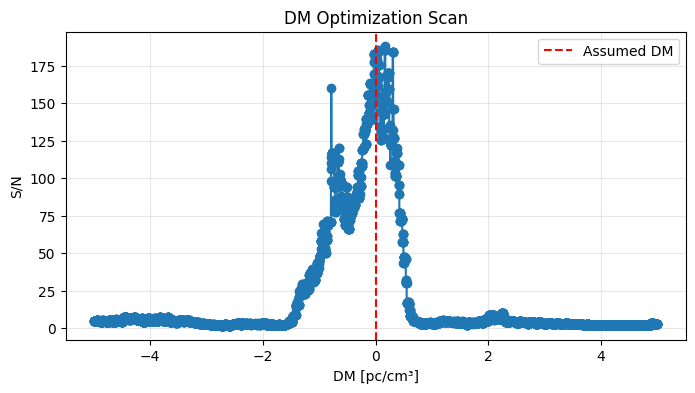

Optimal DM: 0.17 pc/cm³
DM offset: 0.17 pc/cm³


In [4]:
# 1. DM Optimization Check
print("\n=== DM Optimization Check ===")
dms, snrs = dm_optimization_check(
    pipe.dataset.data, 
    pipe.dataset.freq,
    pipe.dataset.time,
    dm_center=0.0,  # Your assumed DM
    dm_range=5.0,
    n_trials=5000
)

plt.figure(figsize=(8, 4))
plt.plot(dms, snrs, 'o-')
plt.axvline(0.0, color='r', linestyle='--', label='Assumed DM')
plt.xlabel('DM [pc/cm³]')
plt.ylabel('S/N')
plt.title('DM Optimization Scan')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

optimal_dm = dms[np.argmax(snrs)]
print(f"Optimal DM: {optimal_dm:.2f} pc/cm³")
print(f"DM offset: {optimal_dm:.2f} pc/cm³")



Burst duration: 0.2 ms
Using window size: 0.1 ms
SNR threshold: 2.0
Successfully measured 5 spectral indices


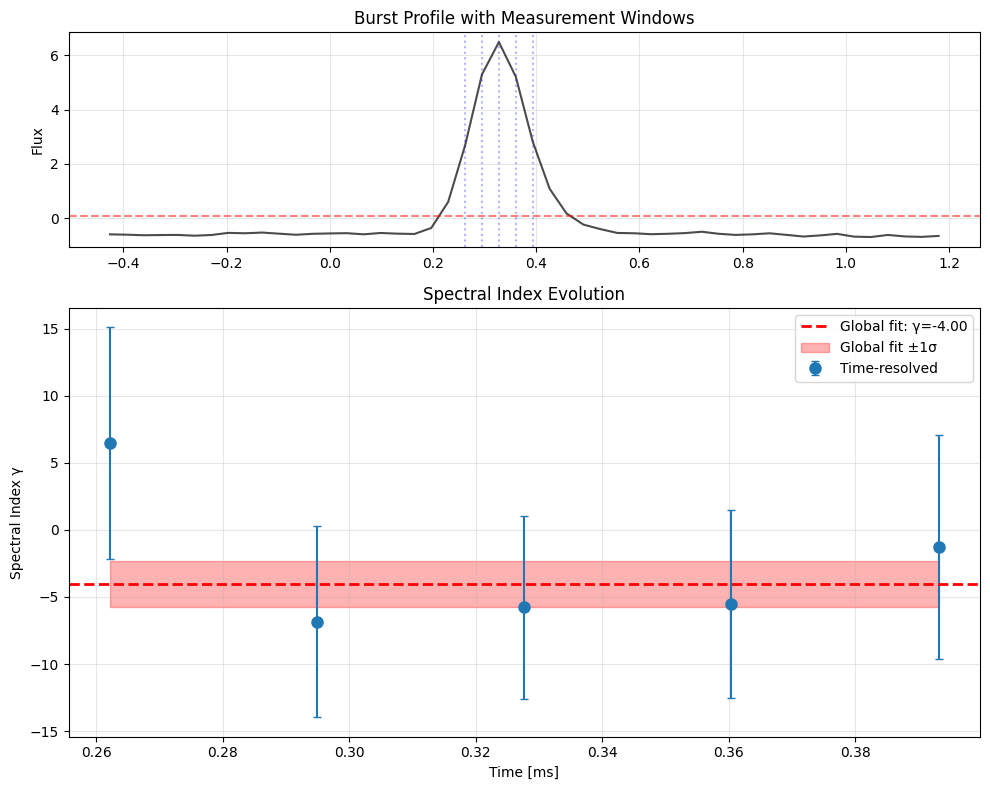


Spectral index evolution test:
χ² = 1.8 with 4 DOF
p-value = 0.763
No significant spectral evolution detected.
Single spectral index model appears adequate.


In [8]:
def adaptive_spectral_evolution(pipe, best_pars, flat, param_names):
    """Run spectral evolution with parameters adapted to the burst"""
    # First, characterize the burst
    data = pipe.dataset.data
    time = pipe.dataset.time
    freq = pipe.dataset.freq
    
    time_profile = np.sum(data, axis=0)
    noise_std = np.std(time_profile[:len(time_profile)//4])
    
    # Use reasonable SNR threshold
    snr_threshold = 2.0  # Changed from 0.01
    burst_mask = time_profile > snr_threshold * noise_std
    
    if not np.any(burst_mask):
        print("No samples above SNR threshold")
        return
    
    # Get burst duration
    burst_indices = np.where(burst_mask)[0]
    burst_duration_ms = (burst_indices[-1] - burst_indices[0]) * (time[1] - time[0])
    
    # Adaptive window size - aim for ~5-10 windows across burst
    window_ms = burst_duration_ms / 8.0
    window_ms = np.clip(window_ms, 0.1, 5.0)  # Keep reasonable bounds
    
    print(f"Burst duration: {burst_duration_ms:.1f} ms")
    print(f"Using window size: {window_ms:.1f} ms")
    print(f"SNR threshold: {snr_threshold}")
    
    # Now run spectral evolution
    from burstfit_robust import spectral_index_evolution
    times, gammas, gamma_errs = spectral_index_evolution(
        data, 
        freq, 
        time,
        window_ms=window_ms,
        min_snr=snr_threshold,
        stride_ms=window_ms/2  # 50% overlap
    )
    
    if len(gammas) > 0:
        print(f"Successfully measured {len(gammas)} spectral indices")
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[1, 2])
        
        # Top panel: burst profile with window positions
        ax1.plot(time, time_profile, 'k-', alpha=0.7)
        ax1.axhline(snr_threshold * noise_std, color='r', linestyle='--', alpha=0.5)
        
        # Show window positions
        for t in times:
            ax1.axvline(t, color='blue', alpha=0.3, linestyle=':')
        
        ax1.set_ylabel('Flux')
        ax1.set_title('Burst Profile with Measurement Windows')
        ax1.grid(True, alpha=0.3)
        
        # Bottom panel: spectral evolution
        ax2.errorbar(times, gammas, yerr=gamma_errs, fmt='o', capsize=3, 
                    markersize=8, label='Time-resolved')
        
        # Show the global fit value
        ax2.axhline(best_pars.gamma, color='r', linestyle='--', linewidth=2,
                   label=f'Global fit: γ={best_pars.gamma:.2f}')
        
        # Add shading for 1-sigma region from global fit
        if 'gamma' in param_names:
            gamma_idx = param_names.index('gamma')
            gamma_std = np.std(flat[:, gamma_idx])
            ax2.fill_between(times, 
                           best_pars.gamma - gamma_std,
                           best_pars.gamma + gamma_std,
                           alpha=0.3, color='red', label='Global fit ±1σ')
        
        ax2.set_xlabel('Time [ms]')
        ax2.set_ylabel('Spectral Index γ')
        ax2.set_title('Spectral Index Evolution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical test
        if len(gammas) > 1:
            chi2_gamma = np.sum((gammas - best_pars.gamma)**2 / gamma_errs**2)
            dof = len(gammas) - 1
            p_value = 1 - sp.stats.chi2.cdf(chi2_gamma, df=dof)
            print(f"\nSpectral index evolution test:")
            print(f"χ² = {chi2_gamma:.1f} with {dof} DOF")
            print(f"p-value = {p_value:.3f}")
            
            if p_value < 0.05:
                print("WARNING: Significant spectral evolution detected!")
                print("The single spectral index model may be inadequate.")
            else:
                print("No significant spectral evolution detected.")
                print("Single spectral index model appears adequate.")
    else:
        print("Failed to measure spectral indices - check parameters")
        print("Possible issues:")
        print("- Burst too weak or too short")
        print("- Window size too large for burst duration")
        print("- Need to adjust SNR threshold")

# Run the adaptive version
adaptive_spectral_evolution(pipe, best_pars, flat, param_names)

Time samples: 50
Time range: -0.4 to 1.2 ms
Time resolution: 0.033 ms
Profile peak: 6.5
Noise std: 0.0
Peak SNR: 182.8

SNR > 3: 8 samples, 0.2 ms duration

SNR > 5: 7 samples, 0.2 ms duration

SNR > 10: 7 samples, 0.2 ms duration


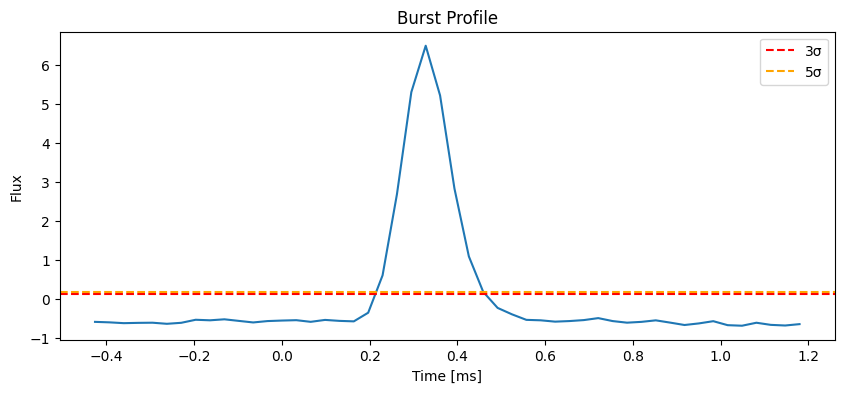

In [9]:
# Debug version to understand the issue
def debug_spectral_evolution(pipe):
    """Check why spectral evolution isn't working"""
    data = pipe.dataset.data
    time = pipe.dataset.time
    
    # Check burst profile
    time_profile = np.sum(data, axis=0)
    noise_std = np.std(time_profile[:len(time_profile)//4])
    
    print(f"Time samples: {len(time)}")
    print(f"Time range: {time[0]:.1f} to {time[-1]:.1f} ms")
    print(f"Time resolution: {time[1]-time[0]:.3f} ms")
    print(f"Profile peak: {np.max(time_profile):.1f}")
    print(f"Noise std: {noise_std:.1f}")
    print(f"Peak SNR: {np.max(time_profile)/noise_std:.1f}")
    
    # Find burst region
    for snr_thresh in [3, 5, 10]:
        burst_mask = time_profile > snr_thresh * noise_std
        if np.any(burst_mask):
            burst_indices = np.where(burst_mask)[0]
            burst_duration = (burst_indices[-1] - burst_indices[0]) * (time[1]-time[0])
            print(f"\nSNR > {snr_thresh}: {np.sum(burst_mask)} samples, {burst_duration:.1f} ms duration")
    
    # Plot to visualize
    plt.figure(figsize=(10, 4))
    plt.plot(time, time_profile)
    plt.axhline(3*noise_std, color='r', linestyle='--', label='3σ')
    plt.axhline(5*noise_std, color='orange', linestyle='--', label='5σ')
    plt.xlabel('Time [ms]')
    plt.ylabel('Flux')
    plt.title('Burst Profile')
    plt.legend()
    plt.show()
    
    return time_profile, noise_std

# Run the debug
profile, noise = debug_spectral_evolution(pipe)

In [10]:
# 2. Scintillation Analysis
print("\n=== Scintillation Analysis ===")

model = FRBModel(
    time=pipe.dataset.time, 
    freq=pipe.dataset.freq, 
    data=pipe.dataset.data,
    dm_init=0.0  # Use the same dm_init as in fit
)
model_dyn = model(best_pars, best_key)

residual = pipe.dataset.data - model_dyn
scint_results = scintillation_analysis(residual, pipe.dataset.freq, pipe.dataset.time)

if not np.isnan(scint_results['decorr_bw']):
    print(f"Decorrelation bandwidth: {scint_results['decorr_bw']:.1f} MHz")
    print(f"Modulation index: {scint_results['modulation_index']:.3f}")
    
    # Plot frequency ACF
    plt.figure(figsize=(8, 4))
    freq_lags = np.arange(len(scint_results['acf_freq'])) - len(scint_results['acf_freq'])//2
    plt.plot(freq_lags * (pipe.dataset.freq[1] - pipe.dataset.freq[0]) * 1000, 
             scint_results['acf_freq'])
    plt.axhline(1/np.e, color='r', linestyle='--', label='1/e level')
    plt.xlabel('Frequency Lag [MHz]')
    plt.ylabel('ACF')
    plt.title('Frequency Autocorrelation of Residuals')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()




=== Scintillation Analysis ===


In [11]:
# 3. Time-Frequency Drift Check
print("\n=== Time-Frequency Drift Check ===")
drift_results = time_frequency_drift_check(
    pipe.dataset.data, 
    pipe.dataset.freq,
    pipe.dataset.time, 
    model_dyn
)

print(f"Drift rate: {drift_results['drift_rate']:.3f} MHz/ms")
print(f"Drift significance: {drift_results['drift_snr']:.1f}σ")

if drift_results['drift_snr'] > 3:
    print("Significant drift detected!")
    # Show before/after drift correction
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    plot_dynamic(ax1, residual, pipe.dataset.time, pipe.dataset.freq, 
                 cmap='coolwarm', vmin=-0.1, vmax=0.1)
    ax1.set_title('Original Residual')
    
    plot_dynamic(ax2, drift_results['drift_corrected_residual'], 
                 pipe.dataset.time, pipe.dataset.freq,
                 cmap='coolwarm', vmin=-0.1, vmax=0.1)
    ax2.set_title('Drift-Corrected Residual')
    
    plt.tight_layout()
    plt.show()      
    



=== Time-Frequency Drift Check ===
Drift rate: 1.018 MHz/ms
Drift significance: 0.0σ


In [27]:
# 4. Spectral Evolution Check
print("\n=== Spectral Index Evolution Check ===")
times, gammas, gamma_errs = spectral_index_evolution(
    pipe.dataset.data, 
    pipe.dataset.freq, 
    pipe.dataset.time,
    window_ms=0.05,  # 2 ms windows
    min_snr=3
)

if len(gammas) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot evolution with error bars
    ax.errorbar(times, gammas, yerr=gamma_errs, fmt='o', capsize=3, label='Time-resolved')
    
    # Show the global fit value
    ax.axhline(best_pars.gamma, color='r', linestyle='--', 
               label=f'Global fit: γ={best_pars.gamma:.2f}')
    
    # Add shading for 1-sigma region from global fit
    if 'gamma' in param_names:
        gamma_idx = param_names.index('gamma')
        gamma_std = np.std(flat[:, gamma_idx])
        ax.fill_between(ax.get_xlim(), 
                       best_pars.gamma - gamma_std,
                       best_pars.gamma + gamma_std,
                       alpha=0.3, color='red', label='Global fit ±1σ')
    
    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Spectral Index γ')
    ax.set_title('Spectral Index Evolution Across Burst')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Check if evolution is significant
    chi2_gamma = np.sum((gammas - best_pars.gamma)**2 / gamma_errs**2)
    dof = len(gammas) - 1
    p_value = 1 - stats.chi2.cdf(chi2_gamma, df=dof)
    print(f"\nSpectral index evolution test:")
    print(f"χ² = {chi2_gamma:.1f} with {dof} DOF")
    print(f"p-value = {p_value:.3f}")
    if p_value < 0.05:
        print("Significant spectral evolution detected!")
else:
    print("Insufficient SNR for spectral index evolution analysis")




=== Spectral Index Evolution Check ===


ValueError: range() arg 3 must not be zero

In [ ]:
# 5. Bootstrap Uncertainties (optional - this is slow!)
if False:  # Set to True to run
    print("\n=== Bootstrap Error Analysis ===")
    boot_uncertainties = bootstrap_uncertainties(
        pipe.dataset.data,
        pipe.dataset.freq, 
        pipe.dataset.time,
        dm_init=0.0,
        best_params=best_pars,
        model_key=best_key,
        n_bootstrap=50,
        n_steps=300
    )
    
    print("Bootstrap uncertainties:")
    for param, (mean, std) in boot_uncertainties.items():
        print(f"{param}: {mean:.3f} ± {std:.3f}")  